# Clusters

In this notebook, we check the cluster output sample

In [1]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")
from main import copacabana
from make_input_files.make_input_datasets import *

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using Modified sklearn.mixture.GMM, modified to allow data weights


In [2]:
import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

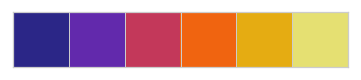

In [3]:
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("CMRmap"))

In [4]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [25]:
master = h5py.File('/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00001.hdf5','r')
master['clusters/copa/'].keys()

[u'emu-r200-z3',
 u'emu-r200-z3-m1',
 u'emu-r200-zw',
 u'emu-r200-zw-m1',
 u'emu-rhod-z3',
 u'emu-rhod-z3-m1',
 u'emu-rhod-zw',
 u'emu-rhod-zw-m1',
 u'g001-r200',
 u'g001-r200-m1',
 u'g001-rhod',
 u'g001-rhod-m1',
 u'g003-r200',
 u'g003-r200-m1',
 u'g003-rhod',
 u'g003-rhod-m1',
 u'g005-r200',
 u'g005-r200-m1',
 u'g005-rhod',
 u'g005-rhod-m1',
 u'test001-rhod']

In [26]:
master.close()

In [5]:
title='Buzzard v2.0'

In [6]:
cfg = '../config_files/config_buzzard_v2.yaml'
# cfg = '../config_files/config_copa_dc2.yaml'
copa = copacabana(cfg)

# run   ='emu-r200-zw'
run    ='test'
cat   = copa.load_copa_out('cluster',run=run)

mask= np.isnan(cat['Ngals'])
cat = cat[np.logical_not(mask)]

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00032.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles


In [7]:
cat.colnames

['MASKFRAC',
 'R200',
 'CID',
 'M200_true',
 'redshift',
 'Ngals',
 'DA',
 'tile',
 'R200_true',
 'Norm',
 'magLim_i',
 'Nbkg_true',
 'RAPER',
 'Nbkg',
 'DEC',
 'Ngals_true',
 'RA']

In [9]:
zcls  = cat['redshift']
r200  = cat['R200']
nbkg  = cat['Nbkg']

ngals = cat['Ngals']
# mu    = cat['MU'] 
norm  = cat['Norm']
# muErr = cat['MU_ERR_JK']

nbkgt = cat['Nbkg_true']
ngalst= cat['Ngals_true']
# mut   = cat['MU_TRUE']
# mutErr= cat['MU_TRUE_ERR_JK']

m200  = cat['M200_true']
r200t = cat['R200_true']

In [10]:
logm  = np.log10(m200)


In [11]:
sys.path.append("/home/s1/jesteves/git/ccopa/notebooks/")
from myplots import *

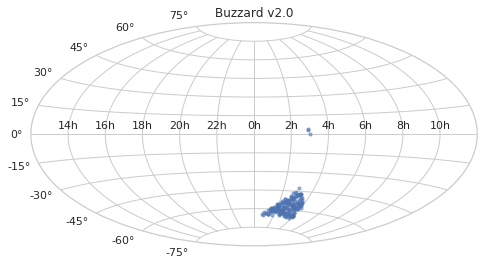

In [12]:
sky_plot(cat['RA'],cat['DEC'],title=title,savefig='sky_plot.png')

### Overall Accuracy

In [15]:
w = np.where(ngalst>1)[0]
residual = (ngals[w]/ngalst[w])
mask2    = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
mask     = remove_outliers(residual,n=2)&(mask2)

xm      = np.mean(residual[mask])
xstd    = np.std(residual[mask])

print(r'mean: %.3f'%(xm))
print(r'rms : %.3f'%(xstd))

mean: 0.970
rms : 0.401


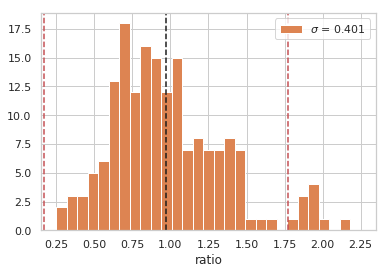

In [16]:
xmin,xmax = 0.25, 2.25
xbins = np.linspace(xmin,xmax,30)
_ = plt.hist(residual,bins=xbins)
_ = plt.hist(residual[mask],bins=xbins,label=r'$\sigma$ = %.3f'%(xstd))
plt.axvline(xm,color='k',ls='--')
plt.axvline(xm+2*xstd,color='r',ls='--')
plt.axvline(xm-2*xstd,color='r',ls='--')

#plt.yscale('log')
plt.xlabel('ratio')
plt.legend()

### Scaling Relations

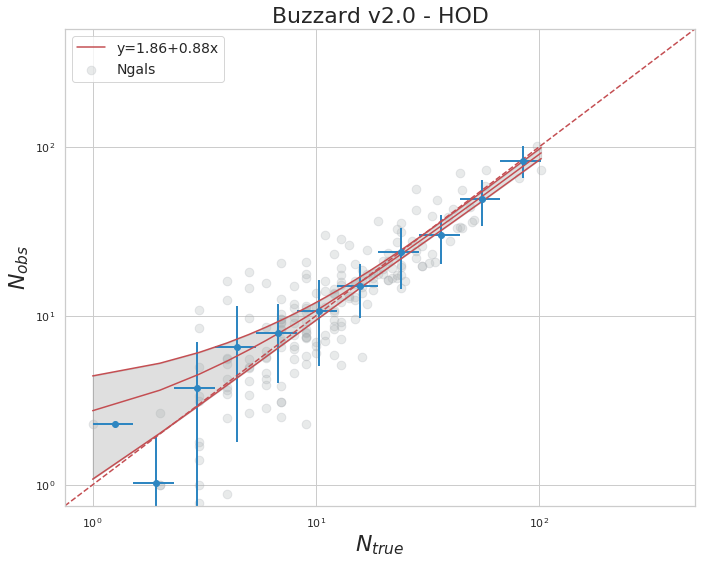

In [17]:
plot_scaling_relation(ngalst,ngals,title=title+' - HOD',xlims=(0.75,500),fit=True)

In [18]:
plot_scaling_relation(mut,mu,xl=r'$\mu_{\star,true}$',yl=r'$\mu_{\star,obs}$',title=title+' - HOD',xlims=(3,3500),fit=True)

NameError: name 'mut' is not defined

#### Residuals

In [19]:
def plot_residual(xvar,yvar1,yvar2, ax=None, xlabel='redshift', xbins=None,log=False):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins(xvar)
    
    residual = (1-yvar2/yvar1)
    if log:
        residual = np.log(yvar2/yvar1)
    mask2    = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    mask     = remove_outliers(residual,n=5)&(mask2)
    if log:
        mask     = remove_outliers(residual,n=5)&(mask2)
    
    nmask    = np.logical_not(mask)
    of       = 1.-1.*np.count_nonzero(mask)/len(yvar1)
    
    keys, xvarb = makeBins(xvar[mask],xbins)
    xvarb_std = np.diff(xbins)/2
    
    residualb = np.array([np.nanmedian(residual[mask][idx]) for idx in keys])
    residualb_std = np.array([np.nanstd(residual[mask][idx]) for idx in keys])
    
    ax.scatter(xvar[nmask],residual[nmask],color='r',alpha=0.25,s=50,label='Outlier fraction: %.2f'%(of))
    ax.scatter(xvar,residual,color='#A6ACAF',alpha=0.25,s=50)
    
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color='#2E86C1',fmt='o')
    print(residualb_std)
    ax.set_xlabel(xlabel,fontsize=18)
    #ax.legend()

In [20]:
def plot_triple_pannel(zcls,ntru,logm,yvar1,yvar2,title='Residuals',save=None,ymin=-1,ymax=1.5):
    ylabel=r'frac. residual'
    ngbins = np.logspace(np.log10(2),1.2*np.nanpercentile(np.log10(yvar2),99),9)
    
    fig, ax = plt.subplots(3, 1, sharey='col', figsize=(10,14))
    fig.subplots_adjust(hspace=0.4,wspace=0.6)
    
    plot_residual(zcls,yvar1,yvar2,ax=ax[0])
    plot_residual(ntru,yvar1,yvar2,ax=ax[2],xlabel=r'$N_{true}$',xbins=ngbins)
    plot_residual(logm,yvar1,yvar2,ax=ax[1],xlabel=r'$\log{M_{200}}$ [$M_{\odot}\, h^{-1}$]')

    #fig.suptitle(title,fontsize=18)

    ax[1].set_ylabel(ylabel,fontsize=24)
    ax[2].set_xscale('log')
    ax[0].set_ylim(ymin,ymax)
    ax[2].set_xlim(0.8*ngbins[0],)
    for i in range(3):
        ax[i].axhline(0.2,color='r',linestyle='--')
        ax[i].axhline(-0.2,color='r',linestyle='--')
    fig.tight_layout()
    
    if save:
        plt.savefig(save,bb_box='tight')
    #fig.clf()
    pass

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[0.30748954 0.71613909 0.43559373 0.70389348 0.32672128 0.56053526
 0.4422443  0.57759047 0.48972724 0.59707677]
[1.0190101  0.46846517 0.62997817 0.47343427 0.30584656 0.26059363
 0.17396796        nan]
[0.82776502 0.61146196 0.47575549 0.41642749 0.60231885 0.56364808
 0.3964575  0.32624254 0.69848041 0.31471458]


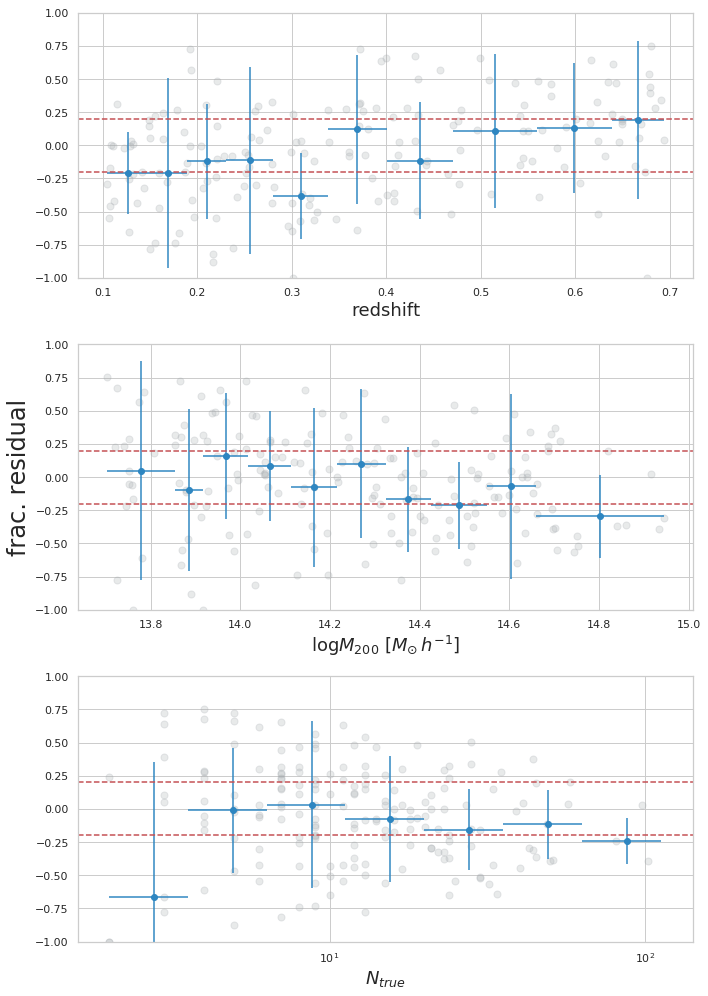

In [21]:
plot_triple_pannel(zcls,ngalst,logm,ngals,ngalst,ymax=1.,save=None)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[0.27349136 0.23298745 0.23496561 0.21968083 0.25299466 0.28861524
 0.29306609 0.24360565 0.27853936 0.2683246 ]
[0.27421801 0.28709353 0.25236339 0.21084443 0.13965771        nan
        nan        nan]
[0.29363922 0.29273782 0.29584579 0.27213795 0.26547235 0.26026016
 0.2710154  0.23832917 0.25155468 0.23170892]


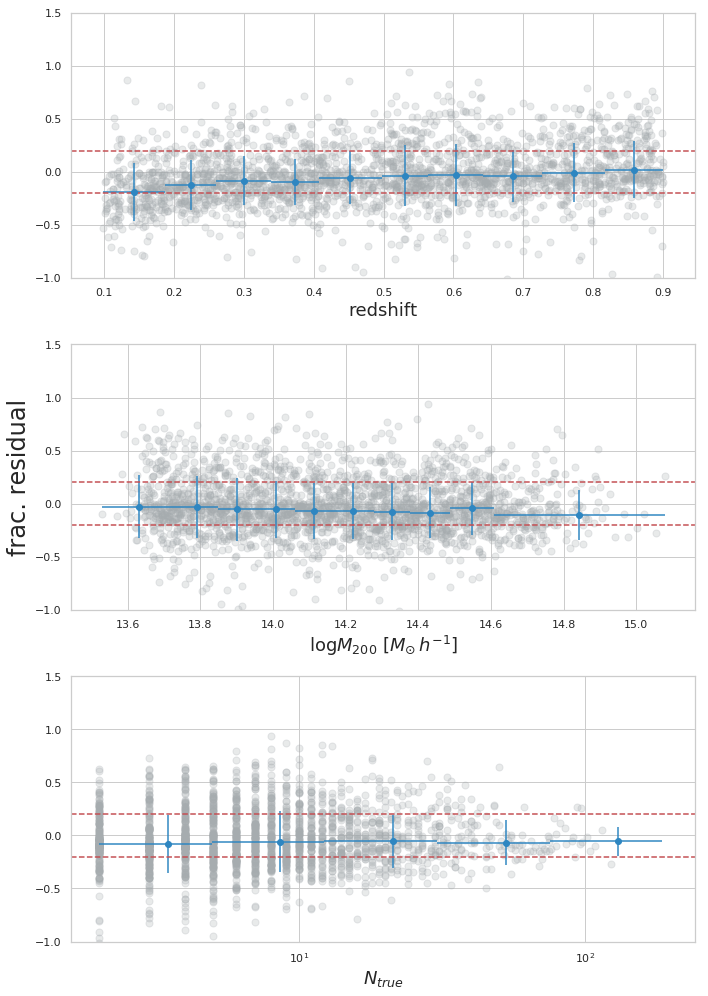

In [41]:
plot_triple_pannel(zcls,ngalst,logm,mu,mut,ymax=1.5,save=None)

myplots.py:90: RuntimeWarning: divide by zero encountered in divide
  residual = (1-yvar2/yvar1)
myplots.py:92: RuntimeWarning: divide by zero encountered in divide
  residual = np.log(yvar2/yvar1)


[0.97773953 0.75875654 0.72251582 0.59251541 0.48337294 0.60194727
 0.4669336  0.4354097  0.36620376 0.34888051]
[0.75998311 0.71786891 0.93545382 0.48421366 0.88832573 0.36670482
 0.49157559 0.49413751 0.61311295 0.44592223]
[0.70857715 0.63710424 0.49659916 0.66578986 0.98017163 0.5969102
 0.49740512 0.45249631 0.57882367 0.53975923]
[0.76117014 0.70910944 0.9522387  0.42609212 0.73334701 0.76959807
 0.40058636 0.54613483 0.5506267  0.52640465]


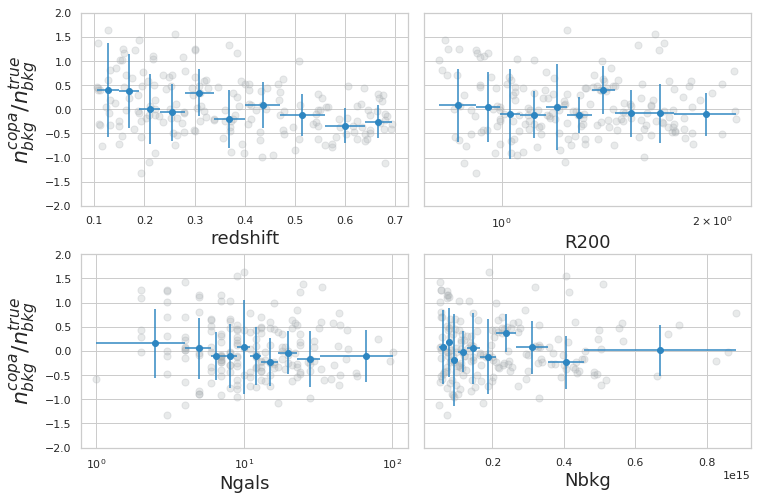

In [22]:
yl = r'$ n_{bkg}^{copa} /n_{bkg}^{true} $'
plot_four_pannel(zcls,r200,ngalst,m200,nbkgt,nbkg,ylabel=yl)

In [23]:
def plot_four_pannel(zcls,r200,ntrue,nbkg,x1,x2,ylabel='y',ylims=(-2,2)):
    fig, ax = plt.subplots(2, 2, sharey='all', figsize=(12,8))
    fig.subplots_adjust(hspace=0.25,wspace=0.05)

    ax = ax.flatten(order='F')

    plot_residual(zcls ,x1,x2,ax=ax[0],log=True)
    plot_residual(r200 ,x1,x2,ax=ax[2],log=True)
    plot_residual(ntrue,x1,x2,ax=ax[1],log=True)
    plot_residual(nbkg ,x1,x2,ax=ax[3],log=True)

    ax[0].set_xlabel('redshift')
    ax[1].set_xlabel('Ngals')
    ax[2].set_xlabel('R200')
    ax[3].set_xlabel('Nbkg')
    ax[1].set_xscale('log')
    ax[2].set_xscale('log')
    ax[0].set_ylim(ylims)
    ax[0].set_ylabel(ylabel,fontsize=22)
    ax[1].set_ylabel(ylabel,fontsize=22)


In [24]:
def plot_r200_identity(r200h,r200,title='Buzzard',ylabel=r'$R_{200}$ [$Mpc\, h^{-1}$]',xlims=[1.,900],ylims=[1.,900],logy=False):
    r200_bins = splitBins(r200)
    if logy:
        r200_bins = np.logspace(np.log10(np.nanmin(r200)+0.01),np.log10(np.nanmax(r200)),11)
#     _, r200_bins = np.histogram(r200,bins=10)
    keys, r200b = makeBins(r200,r200_bins)
    r200b_std = np.diff(r200_bins)/2
    
    r200hb = np.array([np.mean(r200h[idx]) for idx in keys])
    r200hb_std = np.array([np.std(r200h[idx]) for idx in keys])

    fig = plt.figure(figsize=(8,6))
    sc = plt.scatter(r200,r200h,s=75, alpha=0.25, color=gray)#,label='$scatter = %.1f$'%(np.std(ngals-nt))
    plt.errorbar(r200b,r200hb,xerr=r200b_std,yerr=r200hb_std,color=blue,linewidth=2.,fmt='o')
    if not logy:
        plt.plot(np.linspace(xlims[0],xlims[1]),np.linspace(ylims[0],ylims[1]),linestyle='--',color='r')
    
    plt.ylim(ylims)
    plt.xlim(xlims)

    plt.ylabel(ylabel,fontsize=22)
    plt.xlabel(r'$R_{200,hod}$ [$Mpc\, h^{-1}$]',fontsize=22)
    plt.legend(fontsize=14)
    plt.title(title,fontsize=22)
    fig.tight_layout()

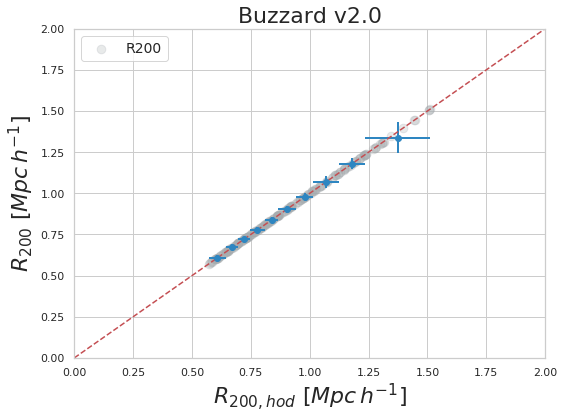

In [25]:
plot_r200_identity(r200*0.7,r200t*0.7,title=title,xlims=[0.,2.0],ylims=[0.,2.])

In [26]:
np.max(r200)

2.161167

In [27]:
def plot_residual_r200(xvar,r200_hod_mass,r200, ax=None, xlabel='redshift'):
    if ax is None: ax = plt.axes()

    xbins = splitBins(xvar)
    keys, xvarb = makeBins(xvar,xbins)
    xvarb_std = np.diff(xbins)/2

    residual = np.log10(r200_hod_mass/r200)

    residualb = np.array([np.nanmean(residual[idx]) for idx in keys])
    residualb_std = np.array([np.nanstd(residual[idx]) for idx in keys])

    ax.scatter(xvar,residual,color='#A6ACAF',alpha=0.6)
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color='#2E86C1',fmt='o')

    ax.set_xlabel(xlabel,fontsize=18)
    # ax.set_ylabel(r'$r_{200}-r_{200,HOD}$ [Mpc $h^{-1}$]',fontsize=18)

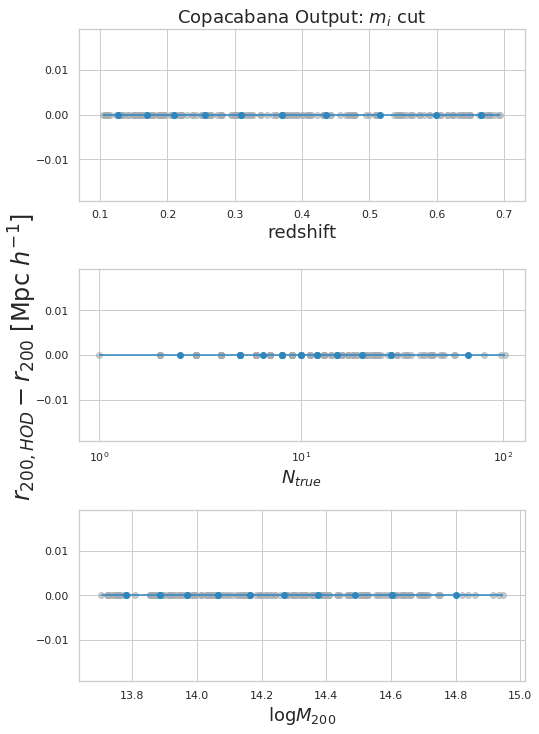

In [28]:
zcls2 = cat['redshift']
r200h2 = cat['R200']
r2002  = cat['R200_true']
m2002  = cat['M200_true']
n1952 = cat['Ngals_true']

fig, ax = plt.subplots(3, 1, sharey='row', figsize=(8,12))
fig.subplots_adjust(hspace=0.4, wspace=0.1)
plot_residual_r200(zcls2,r200h2,r2002,ax=ax[0])
plot_residual_r200(n1952,r200h2,r2002,ax=ax[1],xlabel=r'$N_{true}$')
plot_residual_r200(np.log10(m2002),r200h2,r2002,ax=ax[2],xlabel=r'$\log{M_{200}}$')
# ax[0].set_ylabel(r'$r_{200,HOD}-r_{200}$ [Mpc $h^{-1}$]',fontsize=18)
fig.text(0.03, 0.5, r'$r_{200,HOD}-r_{200}$ [Mpc $h^{-1}$]', ha='center', va='center', rotation='vertical',fontsize=24)
ax[0].set_title('Copacabana Output: $m_{i}$ cut',fontsize=18)
ax[1].set_xscale('log')
plt.savefig('copacabana_r200_residual.png',bb_box='tight')


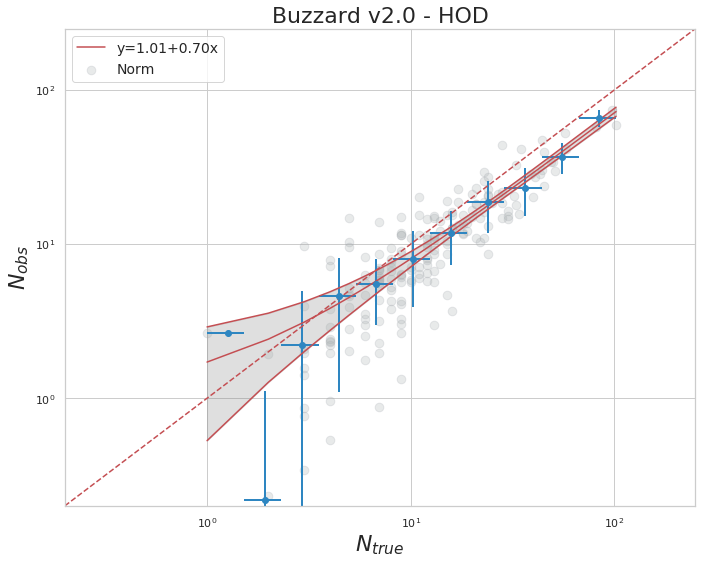

In [29]:
plot_scaling_relation(ngalst,norm,title=title+' - HOD',xlims=(0.2,250),fit=True)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  5.,  3.,  4.,
         2.,  5.,  8.,  2.,  6.,  7.,  2.,  9.,  7., 10.,  4., 11.,  7.,
        10.,  8., 12.,  2.,  5.,  4.,  5.,  5.,  7.,  6.,  5.,  3.,  3.,
         2.,  3.,  4.,  3.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.2       , 0.22166667, 0.24333333, 0.265     , 0.28666667,
        0.30833333, 0.33      , 0.35166667, 0.37333333, 0.395     ,
        0.41666667, 0.43833333, 0.46      , 0.48166667, 0.50333333,
        0.525     , 0.54666667, 0.56833333, 0.59      , 0.61166667,
        0.63333333, 0.655     , 0.67666667, 0.69833333, 0.72      ,
        0.74166667, 0.76333333, 0.785     , 0.80666667, 0.82833333,
        0.85      , 0.87166667, 0.89333333, 0.915     , 0.93666667,
        0.95833333, 0.98      , 1.00166667, 1.02333333, 1.045     ,
        1.06666667, 1.08833333, 1.11      , 1.13166667, 1.15333333,
        1.175     , 1.19666667, 1.21833333, 1.

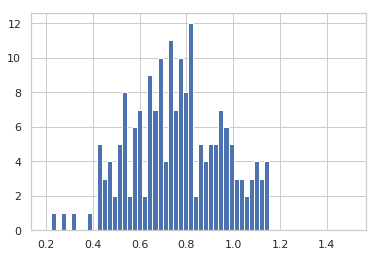

In [30]:
ratio = np.log10(norm/(ngals+0.001))
mask = np.logical_not(np.isnan(ratio))
plt.hist(10**ratio[mask],bins=np.linspace(0.2,1.5,61))

In [256]:
np.count_nonzero(np.isnan(ratio))

83

In [257]:
w = np.where(10**ratio>0.90)[0]

In [258]:
w.size

467

In [259]:
10**np.nanpercentile(ratio,[25,50,75])

array([0.53240919, 0.72216399, 0.87536526])